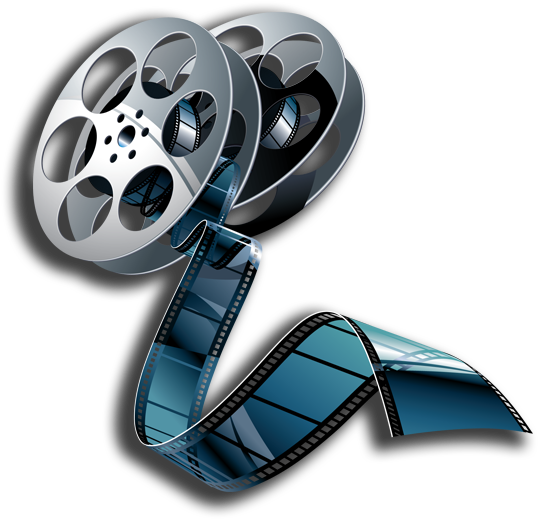

# Microsoft Movie Analysis #

***Authors: Doug, Michael, Carlos***

## Overview

This project presents analysis of past movie outcomes based on movies' budget, seasonality, and genre, and can be used to forecast future movie outcomes based on these factors. These forecasts show the strength and impact of these variables which should be considered by Microsoft.

## Business Problem

Microsoft Movie Studio will be able to make a more effective decision based on statistical analysis of several variables and their outcomes. These variables include production budget, seasonality, and genre. We decided that these were the driving factors on box office outcomes. These questions are important from a business perspective because they help optimize the probability of successful project outcomes. 


## Data Understanding

IMDB, Box Office Mojo, and TheNumbers had great movie datasets which contained information about release dates, domestic gross, worldwide gross, budget, rating, genre, actors, actresses, and directors. We analyzed these datasets to draw several conclusions.
We used a customized dataset which combined "Box Office Mojo movie gross", "IMDB title basics", and "TheNumbers movie budgets". I found that there is a moderate positive correlation between 'Budget' and 'Domestic Gross', and 'Budget' and 'Worldwide Gross'. The statistical method used to quantify this was Pearson's correlation coefficient 'r'.

***

In [3]:
# Import standard packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import gzip
import sqlite3
import csv
import numpy as np
import seaborn as sns

In [4]:
# Load dataset 1 'bom.movie_gross' obtained from Box Office Mojo
df1 = pd.read_csv('data/zippedData/bom.movie_gross.csv.gz')
df1 = df1.rename(columns = {'title':'movie'})

# Load dataset 4 'imbd.title.basics' obtained from IMDB
df4 = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')
df4 = df4.rename(columns = {'primary_title':'movie'})

# Load dataset 11 'tn.movie_budgets' from The-Numbers
df11 = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [5]:
# Strip '$' and ',' from the dataset and convert to int64 in order to manipulate the data
df11['worldwide_gross'] = df11['worldwide_gross'].str[1:]
df11['worldwide_gross'] = df11['worldwide_gross'].str.replace(',', '').astype(np.int64)
df11['domestic_gross'] = df11['domestic_gross'].str[1:]
df11['domestic_gross'] = df11['domestic_gross'].str.replace(',', '').astype(np.int64)
df11['production_budget'] = df11['production_budget'].str[1:]
df11['production_budget'] = df11['production_budget'].str.replace(',', '').astype(np.int64)

# Filter the data to our criteria
production = df11[df11.production_budget < 1000000].index
df11.drop(production, inplace=True)
worldwide = df11[df11.worldwide_gross < 1000000].index
df11.drop(worldwide, inplace=True)
df11.set_index('movie')

,id,release_date,production_budget,domestic_gross,worldwide_gross
movie,,,,,
Avatar,1,"Dec 18, 2009",425000000,760507625,2776345279
Pirates of the Caribbean: On Stranger Tides,2,"May 20, 2011",410600000,241063875,1045663875
Dark Phoenix,3,"Jun 7, 2019",350000000,42762350,149762350
Avengers: Age of Ultron,4,"May 1, 2015",330600000,459005868,1403013963
Star Wars Ep. VIII: The Last Jedi,5,"Dec 15, 2017",317000000,620181382,1316721747
...,...,...,...,...,...
Fiza,59,"Sep 8, 2000",1000000,623791,1179462
Ajami,60,"Feb 3, 2010",1000000,621859,2721096
The Future,62,"Jul 29, 2011",1000000,568662,1239174


In [6]:
# Merge the three dataframes together to get 'master' dataframe "BigFrame"
BigFrame = df11.merge(df1, on='movie').merge(df4, on='movie').drop\
                (columns=['tconst', 'original_title', 'start_year', 'id', 'domestic_gross_y'])
# Create 'month' column in order to manipute the data
BigFrame = BigFrame.drop_duplicates(subset='movie').set_index('movie')
BigFrame['month'] = BigFrame['release_date'].str[:3]
# Drop rows with missing values
BigFrame = BigFrame.dropna()
BigFrame.dropna(inplace=True)
# Final dataset has 967 rows

In [7]:
#Preview of our final dataset:
BigFrame.head()

,release_date,production_budget,domestic_gross_x,worldwide_gross,studio,foreign_gross,year,runtime_minutes,genres,month
movie,,,,,,,,,,
Pirates of the Caribbean: On Stranger Tides,"May 20, 2011",410600000,241063875,1045663875,BV,804600000,2011,136.0,"Action,Adventure,Fantasy",May
Avengers: Age of Ultron,"May 1, 2015",330600000,459005868,1403013963,BV,946400000,2015,141.0,"Action,Adventure,Sci-Fi",May
Avengers: Infinity War,"Apr 27, 2018",300000000,678815482,2048134200,BV,"1,369.5",2018,149.0,"Action,Adventure,Sci-Fi",Apr
Justice League,"Nov 17, 2017",300000000,229024295,655945209,WB,428900000,2017,120.0,"Action,Adventure,Fantasy",Nov
Spectre,"Nov 6, 2015",300000000,200074175,879620923,Sony,680600000,2015,148.0,"Action,Adventure,Thriller",Nov


## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [9]:
#This cell provides specified information regarding mean and median for budget, domestic gross, and worldwide gross.

#budget
prod_mean = BigFrame['production_budget'].mean()
prod_median = BigFrame['production_budget'].median()
print(f'Production Budget Mean: {prod_mean}')
print(f'Production Budget Median: {prod_median}')
#domestic gross
domestic_mean = BigFrame['domestic_gross_x'].mean()
domestic_median = BigFrame['domestic_gross_x'].median()
print(f'Domestic Gross Mean: {domestic_mean}')
print(f'Domestic Gross Median: {domestic_median}')
#worldwide gross
ww_mean = BigFrame['worldwide_gross'].mean()
ww_median = BigFrame['worldwide_gross'].median()
print(f'Worldwide Gross Mean: {ww_mean}')
print(f'Worldwide Gross Median: {ww_median}')

Production Budget Mean: 55748022.38883144
Production Budget Median: 34000000.0
Domestic Gross Mean: 73692708.0196484
Domestic Gross Median: 43313890.0
Worldwide Gross Mean: 186315684.35470527
Worldwide Gross Median: 90552675.0


In [10]:
#Pearson Correlation

BigFrame.corr()

,production_budget,domestic_gross_x,worldwide_gross,year,runtime_minutes
production_budget,1.000000,0.676845,0.764780,0.061826,0.346394
domestic_gross_x,0.676845,1.000000,0.935591,0.110967,0.282302
worldwide_gross,0.764780,0.935591,1.000000,0.124869,0.303560
year,0.061826,0.110967,0.124869,1.000000,0.081474
runtime_minutes,0.346394,0.282302,0.303560,0.081474,1.000000


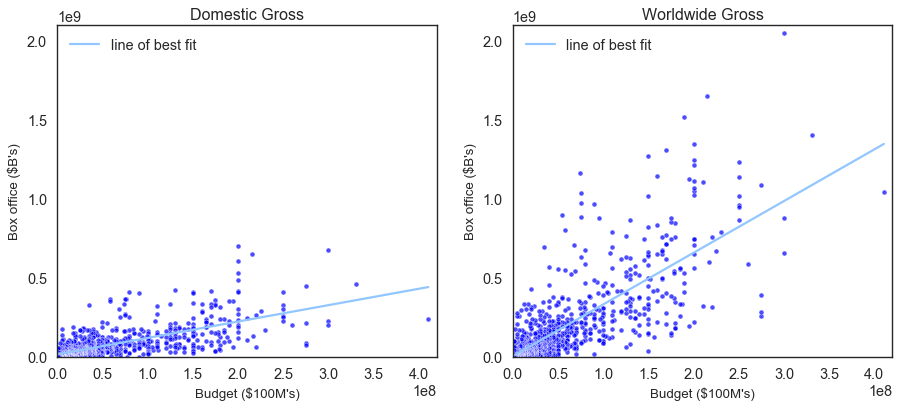

In [63]:
#side by side plots w/ same y axis: domestic vs global
#This shows that movies which transcended cultural and geographical barriers paid off in a big way.
#Much of the box office revenue generated by successful movies came from abroad.
# Production budget and world wide gross have a r value of 0.765.
# Production budget and domestic gross have a r value of 0.677.

plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(ncols = 2, figsize = (12, 5))
x = BigFrame['production_budget']
y = BigFrame['domestic_gross_x']

ax[0].scatter(x, y, alpha = 0.7)
ax[0].set_title('Domestic Gross')
ax[0].set_xlabel("Budget ($100M's)")
ax[0].set_ylabel("Box office ($B's)")
ax[0].set_xlim([0, 420000000])
ax[0].set_ylim([0, 2100000000])
ax[0].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), label = 'line of best fit')
ax[0].legend(loc = "upper left");

wwx = BigFrame['production_budget']
wwy = BigFrame['worldwide_gross']

ax[1].scatter(wwx, wwy, alpha = 0.7)
ax[1].set_title('Worldwide Gross')
ax[1].set_xlabel("Budget ($100M's)")
ax[1].set_ylabel("Box office ($B's)")
ax[1].set_xlim([0, 420000000])
ax[1].set_ylim([0, 2100000000])
ax[1].plot(np.unique(wwx), np.poly1d(np.polyfit(wwx, wwy, 1))(np.unique(wwx)), label = 'line of best fit')
ax[1].legend(loc = "upper left");

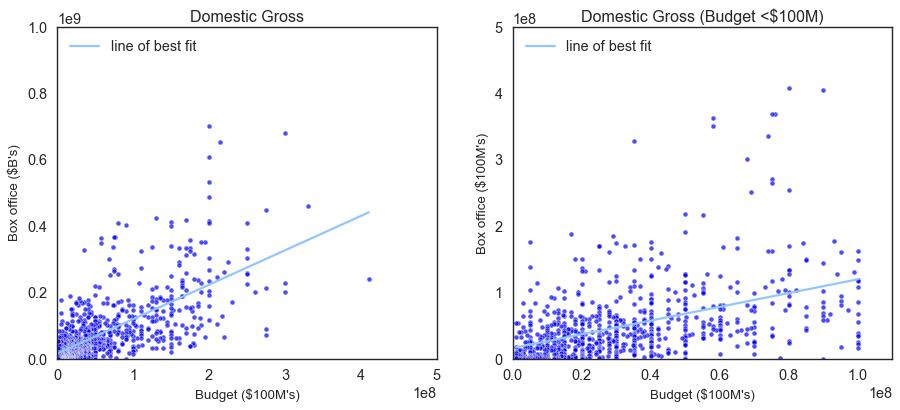

In [67]:
#plot -- Budget & Domestic Gross, overview
plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(ncols = 2, figsize = (12, 5))
x = BigFrame['production_budget']
y = BigFrame['domestic_gross_x']

#first graph, domestic gross all values
ax[0].scatter(x, y, alpha = 0.7)
ax[0].set_title('Domestic Gross')
ax[0].set_xlabel("Budget ($100M's)")
ax[0].set_ylabel("Box office ($B's)")
ax[0].set_xlim([0, 500000000])
ax[0].set_ylim([0, 1000000000])
ax[0].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), label = 'line of best fit')
ax[0].legend(loc = "upper left");

#new df BigFrame100 for production budget movies under $100M
BigFrame100 = BigFrame[BigFrame['production_budget'] <= 100000000]
x100 = BigFrame100['production_budget']
y100 = BigFrame100['domestic_gross_x']

#second graph, Budget < $100M
ax[1].scatter(x100, y100, alpha = 0.7)
ax[1].set_title('Domestic Gross (Budget <$100M)')
ax[1].set_xlabel("Budget ($100M's)")
ax[1].set_ylabel("Box office ($100M's)")
ax[1].set_xlim([0, 110000000])
ax[1].set_ylim([0, 500000000])
ax[1].plot(np.unique(x100), np.poly1d(np.polyfit(x100, y100, 1))(np.unique(x100)), label = 'line of best fit')
ax[1].legend(loc = "upper left");

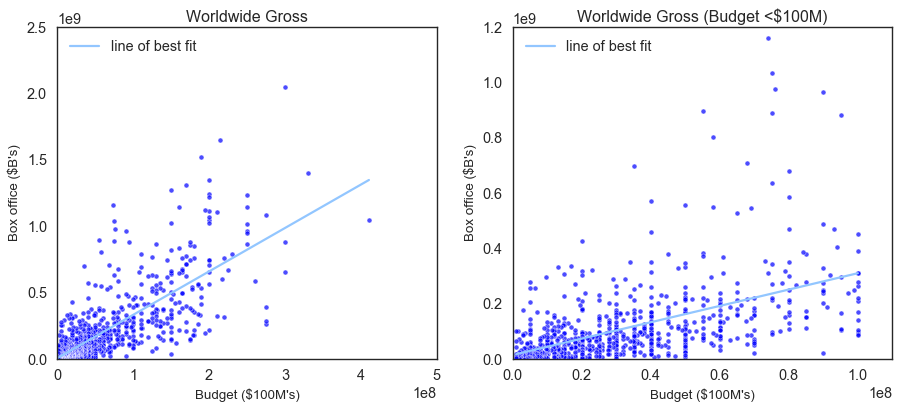

In [66]:
#plot -- Budget & Worldwide Gross, overview
plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(ncols = 2, figsize = (12, 5))
wwx = BigFrame['production_budget']
wwy = BigFrame['worldwide_gross']

#first graph, worldwide gross all values
ax[0].scatter(wwx, wwy, alpha = 0.7)
ax[0].set_title('Worldwide Gross')
ax[0].set_xlabel("Budget ($100M's)")
ax[0].set_ylabel("Box office ($B's)")
ax[0].set_xlim([0, 500000000])
ax[0].set_ylim([0, 2500000000])
ax[0].plot(np.unique(wwx), np.poly1d(np.polyfit(wwx, wwy, 1))(np.unique(wwx)), label = 'line of best fit')
ax[0].legend(loc = "upper left");

#new df BigFrame100 for production budget movies under $100M
BigFrame100 = BigFrame[BigFrame['production_budget'] <= 100000000]
x100 = BigFrame100['production_budget']
ww100 = BigFrame100['worldwide_gross']

#second graph, Budget < $100M
ax[1].scatter(x100, ww100, alpha = 0.7)
ax[1].set_title('Worldwide Gross (Budget <$100M)')
ax[1].set_xlabel("Budget ($100M's)")
ax[1].set_ylabel("Box office ($B's)")
ax[1].set_xlim([0, 110000000])
ax[1].set_ylim([0, 1200000000])
ax[1].plot(np.unique(x100), np.poly1d(np.polyfit(x100, ww100, 1))(np.unique(x100)), label = 'line of best fit')
ax[1].legend(loc = "upper left");

In [71]:
# These graphs demonstrate the correlation between budget and box office performance domestically and worldwide.
# Some of the films that had the greatest returns on investment (ROI) were in the $20M-$100M budget range.
# Multiple films were able to gain >400% returns domestically and >1000% worldwide.
# Budget has a strong positive correlation to box office.
# Geographically transcendant films with a budget of <$100M had the greatest ROI (%).
# Movies with higher budgets brought in the largest profit margins.

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

The median production budget was 34,000,000, while the mean production budget was ~55,748,022.
This is because some films have much higher budgets compared to the average.


The median domestic gross was 43,313,890 while the mean domestic gross was 73,692,708.
The median worldwide gross was 90,552,675 while the mean worldwide gross was ~186,315,684.
This indicates that the more successful films were able to reach a huge global audience.
These films transcended cultural and geographical barriers.


Production budget and world wide gross have a r value of 0.765.
Production budget and domestic gross have a r value of 0.677.
This indicates a strong positive correlation between budget and worldwide gross (r>0.7).
This also indicates a moderate to strong positive correlation between budget and domestic gross (0.3<=r<=0.7).
Higher budget movies did better internationally and domestically.

Some of the films that had the greatest returns on investment (ROI) were in the 20M-100M budget range.
Multiple films were able to gain >400% returns domestically and >1000% worldwide.
Budget has a strong positive correlation to box office. Geographically transcendant films with a budget of <100M had the greatest ROI. Movies with higher budgets brought in the largest profit margins.

The model fits the data well. 
I am confident that my results would generalize for all movie data, assuming inflation-adjusted values and technological advancements. I am confident that this model gives a good guideline of where Microsoft should go when seeking to maximize
ROI or profit margin.

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***

I would recommend the business to pursue universally acceptable themes. I would recommend the business to either stick inside the 20M-100M budget range if their objective is ROI or I would recommend the business to exceed 200M budget if their objective is to maximize profit margin.

Some reasons my analysis might not fully solve the problem is that I did not graph the actual rate of returns curve or other derivatives.

I could dive deeper into the dataset stastically in the future.